# Notebook : Création d'une modélisation 2D via script

Afin de créer une simulation 2D, il est nécessaire de :
 
  - créer une instance "prev_sim2D" en lui passant en argument le chemin d'accès complet et le nom générique de la simulation
  - définir un contour vectoriel/polygone délimitant la zone de travail
  - (optionnel) définir une "grille magnétique" servant d'accroche des vertices des polygones --> permet de s'aligner entre différentes modélisations par ex.
  - définir la résolution spatiale du maillage sur lequel les données (topo, frottrement, inconnues...) seront fournies initialement
  - définir des contours/polygones des blocs et leur résolution spatiale respective
  - appeler le mailleur (appel au code Fortran)
  - créer les matrices obligatoires et les remplir avec les valeurs souhaitées (via script(s) ou GUI)
  - créer les bords potentiels pour les conditons aux limites (.sux, .suy)
  - imposer les conditions aux limites nécessaires (info : rien == imperméable)
  - paramétrer le problème
  - exécuter le calcul
  - traiter les résultats
  

## Import des modules

In [3]:
from wolfhece.mesh2d.wolf2dprev import prev_sim2D
from wolfhece.PyVertexvectors import zone, Zones, vector, wolfvertex
from wolfhece.wolf_array import WolfArray, WolfArrayMB, header_wolf
from wolfhece.wolfresults_2D import Wolfresults_2D
from wolfhece.mesh2d.cst_2D_boundary_conditions import BCType_2D, Direction, revert_bc_type

from tempfile import TemporaryDirectory
from pathlib import Path
import numpy as np
from datetime import datetime as dt
from datetime import timezone as tz
from datetime import timedelta as td
from typing import Literal, Union
import logging

## Définition du répertoire de travail

In [4]:
outdir = Path(r'test')
outdir.mkdir(exist_ok=True) # Création du dossier de sortie
print(outdir.name)

test


### Vérification de la présence du code de calcul

Retourne le chemin d'accès complet au code

In [5]:
wolfcli = prev_sim2D.check_wolfcli() # méthode de classe, il n'est donc pas nécessaire d'instancier la classe pour l'appeler

if wolfcli:
    print('Code found : ', wolfcli)
else:
    print('Code not found !')

Code found :  D:\ProgrammationGitLab\HECEPython\wolfhece\libs\wolfcli.exe


### Création d'un objet simulation 2D

In [6]:
# Passage en attribut du répertoire de travail auquel on a ajouté le nom générique de la simulation.
# "clear" permet de supprimer les fichiers de la simulation précédente.
newsim = prev_sim2D(fname=str(outdir / 'test'), clear=True)

# Un message de type "logging.info" est émis car aucun fichier n'a été trouvé. Ceci est normal !
# Si un fichier est trouvé, il est chargé.

### Géométrie du problème

Domaine carré de taille totale 1.0 m x 1.0 m.

### Mode de définition

Il faut définir un polygone/contour extérieur du domaine à modéliser.

Il existe six manières de travailler :
 1. créer un objet "vector" et encoder ses coordonnées - via une classe "vector" -- voir [wolfhece.PyVertexvectors](https://wolf.hece.uliege.be/autoapi/wolfhece/PyVertexvectors/index.html)
 1. définir les bornes spatiales souhaitées
 1. définir l'origine, la taille de maille et le nombre de mailles dans chaque direction
 1. fournir un objet header
 1. sur base d'une matrice existante - emprise totale
 1. sur base d'une matrice existante - contour généré sur base de son masque

En interne, ces 6 procédures vont toujours revenir à définir un contour/polygone vectoriel, seule donnée acceptée par le code Fortran.

## Etapes de mise en place

Il faut définir un polygone/contour extérieur du domaine à modéliser.

In [7]:
# Grille magnétique - dx et dy sont les pas de la grille [m], origx et origy sont les coordonnées du premier point de la grille.
# Les coordonnées seront alignées sur la grille magnétique par la routine align2grid -- https://wolf.hece.uliege.be/autoapi/wolfhece/wolf_array/index.html#wolfhece.wolf_array.header_wolf.align2grid
newsim.set_magnetic_grid(dx=1., dy=1., origx=0., origy=0.)

# ***** CHOIX *****

# Choisir 1 des 3 options suivantes pour définir le contour externe de la simulation
# ----------------------------------------------------------------------------------

choices = [(1, 'set_external_border_vector'),
           (2, 'set_external_border_xy'),
           (3, 'set_external_border_nxny'),
           (4, 'set_external_border_header'),
           (5, 'set_external_border_wolfarray - mode emprise'),
           (6, 'set_external_border_wolfarray - mode contour')]

choice = 1

if choice not in [c[0] for c in choices]:

    logging.error('Invalid choice !')

elif choice == 1:

    # Define the extrenal contour
    extern = vector()
    extern.add_vertex(wolfvertex(0., 0.))
    extern.add_vertex(wolfvertex(1., 0.))
    extern.add_vertex(wolfvertex(1., 1.))
    extern.add_vertex(wolfvertex(0., 1.))
    extern.close_force()

    print('Nombre de vertices : ', extern.nbvertices)
    print('5 vertices car la polygone est fermé et le dernier point est aux mêmes coordonnées que le premier.')

    # Transfert du polygone comme contour externe de simulation.
    # Le contour externe est la limite de maillage.
    # Ensemble, les polygones de blocs doivent entourer complètement le contour externe.
    newsim.set_external_border_vector(extern)

elif choice == 2:

    # via des bornes
    newsim.set_external_border_xy(xmin= 0., xmax= 1., ymin= 0., ymax= 1.)

elif choice == 3:

    # encore via une description de la matrice
    # ATTENTION : ici dx et dy ne sont pas nécessairement les mêmes que ceux du maillage fin.

    newsim.set_external_border_nxny(xmin= 0, ymin=0., nbx= 10, nby= 10, dx= 0.1, dy= 0.1)

elif choice == 4:

    # Ici rien de bien intéressant vis-à-vis du choix précédent mais il est possible
    # d'obtenir un header depuis n'importe quelle matrice

    header = header_wolf()
    header.origx = 0.
    header.origy = 0.
    header.dx = 0.1
    header.dy = 0.1
    header.nbx = 10
    header.nby = 10

    newsim.set_external_border_header(header)

elif choice == 5:
    # On peut aussi choisir de définir le contour externe à partir
    # d'une matrice de donnée de type WolfArray

    # Mode emprise/header

    # Comme on n'a pas de données chargées, on crée une matrice de toute pièce.

    header = header_wolf()
    header.origx = 0.
    header.origy = 0.
    header.dx = 1.
    header.dy = 1.
    header.nbx = 1
    header.nby = 1

    src_array = WolfArray(srcheader=header)

    newsim.set_external_border_wolfarray(src_array, mode='header', abs=True)

    # L'emprise n'a pas besoin que la matrice soit masquée, mais c'est possible.
    # Dans ce dernier cas, le masque est ignoré lors de la création de l'emprise.

elif choice == 6:
    # On peut aussi choisir de définir le contour externe à partir
    # d'une matrice de données de type WolfArray

    # Mode contour/masque

    # Comme on n'a pas de données chargées, on crée une matrice de toute pièce.
    #
    # ATTENTIOn : la recherche d'un contour demande que la matrice soit bornée par des valeurs masquées.

    header = header_wolf()
    header.origx = -1.
    header.origy = -1.
    header.dx = 1.
    header.dy = 1.
    header.nbx = 3
    header.nby = 3

    src_array = WolfArray(srcheader=header)


    # complete way
    src_array.array[0,:] = 0.
    src_array.array[-1,:] = 0.
    src_array.array[:,0] = 0.
    src_array.array[:,-1] = 0.
    src_array.mask_data(src_array.nullvalue)

    # or more simply
    #src_array.nullify_border(width=1)

    newsim.set_external_border_wolfarray(src_array, mode='contour', abs=True)

# ***** FIN DU CHOIX *****

# Par défaut, les coordonnées du polygone seront translatées pour le que point (xmin, ymin) soit en (0, 0).
# Infos de translation dans le fichier '.trl'
# Pour éviter la translation, on peut modifier la propriété "translate_origin2zero".
newsim.translate_origin2zero = True

# Choix du pas spatial de maillage fin [m].
newsim.set_mesh_fine_size(dx=0.1, dy=0.1)

# Ajout d'un bloc avec son pas spatial spécifique [m].

# On peut définir un contour particulier ou réutiliser le contour externe.

extern = newsim.external_border

newsim.add_block(extern, dx=0.2, dy=0.2)

# (optionnel) Ajout d'autres blocs ...

# Maillage du problème
#   - création d'un fichier sans extension (vide) -- utile pour rétrocompatibilité avec les versions précédentes de WOLF.
#   - écriture sur disque du fichier de description du maillage (.bloc)
#   - calcul de l'emprise "fine" (ne peut être fait qu'une fois tous les blocs définis car dépend de la résolution spatiale maximale des blocs)
#   - appel au code Fortran (phase de maillage uniquement) -- wolfcli doit être défini -- commande "run_wolf2d_prev" avec argument "genfile='/path/to/file'"
#   - le Fortran va créer les fichiers :
#       - ".mnap" maillage des blocs et relations entre blocs
#       - ".nfo" sorties écran du code Fortran
#       - ".xy"  contour externe du maillage (pour interface graphique)
#       - ".blx" et ".bly" bords libres du maillage MB (utiles uniquement pour développeurs Fortran)
#       - ".cmd" fichier d'interaction avec code Fortran en cours de calcul
#   - création du fichier ".napbin" par le code Python (emprise fine sur lequel les données doivent être fournies) -- servira de "masque" pour les matrices de données
if newsim.mesh():
    print('Meshing done !')
else:
    print('Meshing failed !')

# Création des matrices de données - emprise fine - format binaire [np.float32] - shape (nbx, nby)
#   - ".top"   fichier de topographie [m]
#   - ".hbin"  condition initiale de hauteur d'eau [m]
#   - ".qxbin" condition initiale de débit spécifique selon x [m²/s]
#   - ".qybin" condition initiale de débit spécifique selon y [m²/s]
#   - ".frot"  coefficient de frottement (loi par défaut : Manning -- Unités de "n" [s/m^(1/3) -- inverse du 'K' de Strickler]) -- Valeur par défaut : 0.04
#   - ".inf"   zonage d'infiltration -- à ne pas confondre avec le fichier ".fil" qui contiendra les valeurs de débits d'infiltration [m³/s]

# Si "with_tubulence" est True, les fichiers ".kbin" et ".epsbin" seront créés en plus et contiendront l'énergie cinétique turbulente.
newsim.create_fine_arrays(default_frot=0.04, with_tubulence=False)


# Recherches des bords conditions aux limites potentiels sur base de la matrice ".napbin" et écriture des fichiers ".sux" et ".suy"
#   - mode de recherche : bord séparant une valeur masqué d'une valeur non masquée -- bouclages succesifs selon X et Y
#   - ".sux"  énumération des indices [i,j] de la maille fine située à droite d'un bord orienté selon Y     --> [i, j] relatif au bord [i-1/2, j]
#   - ".suy"  énumération des indices [i,j] de la maille fine située au-dessus d'un bord orienté selon X    --> [i, j] relatif au bord [i    , j-1/2]
newsim.create_sux_suy()


Nombre de vertices :  5
5 vertices car la polygone est fermé et le dernier point est aux mêmes coordonnées que le premier.
Meshing done !


### Synthèse de l'emprise spatiale

Il est possible d'afficher les informations du maillage fin ou MB via "get_header" et/ou "get_header_MB"

https://wolf.hece.uliege.be/autoapi/wolfhece/mesh2d/wolf2dprev/index.html#wolfhece.mesh2d.wolf2dprev.prev_sim2D.get_header

https://wolf.hece.uliege.be/autoapi/wolfhece/mesh2d/wolf2dprev/index.html#wolfhece.mesh2d.wolf2dprev.prev_sim2D.get_header_MB


Dans ce cas précis, shape == (18, 18) car la maillage fin est d'une résolution (0.1, 0.1) et la taille de bloc maximale est de (0.2, 0.2)

Soit (10x10) pour la domaine carré de (1.0, 1.0) à une résolution de (0.1, 0.1) auquel on ajoute une frange correspondant à (dx_max + 2 * dx_fin) de part et d'autre. 

**Cette frange est nécessaire pour s'assurer de disposer d'assez d'espace pour stocker les relations de voisinage entre blocs dans les matrices et de conserver au moins une frange masquée sur tout le pourtour.**

Donc (10 + 2 * (0.2 + 2 * 0.1) / 0.1, 10 + 2 * (0.2 + 2 * 0.1) / 0.1) = (18, 18)

La largeur de frange est aussi ce qui explique les valeurs de l'origine (-0.4, -0.4). Ceci afin de conserver le (0.0, 0.0) au (xmin, ymin) du polygone extérieur de maillage.

In [8]:
print(newsim.get_header())

Shape  : 18 x 18 
Resolution  : 0.1 x 0.1 
Spatial extent : 
   - Origin : (-0.4 ; -0.4) 
   - End : (1.4 ; 1.4) 
   - Widht x Height : 1.8 x 1.8 
   - Translation : (0.0 ; 0.0)
Null value : 0.0




Le même type d'information est disponible en MB.

In [9]:
print(newsim.get_header_MB())

Shape  : 18 x 18 
Resolution  : 0.1 x 0.1 
Spatial extent : 
   - Origin : (-0.4 ; -0.4) 
   - End : (1.4 ; 1.4) 
   - Widht x Height : 1.8 x 1.8 
   - Translation : (0.0 ; 0.0)
Null value : 0.0

Number of blocks : 1

Block block1 : 

Shape  : 11 x 11 
Resolution  : 0.2 x 0.2 
Spatial extent : 
   - Origin : (-0.19999999999999996 ; -0.19999999999999996) 
   - End : (2.0 ; 2.0) 
   - Widht x Height : 2.2 x 2.2 
   - Translation : (-0.4 ; -0.4)
Null value : 0.0




### Un peu d'aide sur les fichiers, leur contenu et le type de stockage

In [10]:
print(newsim.help_files())

Text files
----------
Infiltration hydrographs [m³/s] : .fil
Resulting mesh [-] : .mnap
Translation to real world [m] : .trl


Fine array - monoblock
----------------------
Mask [-] : .napbin [int16]
Bed Elevation [m] : .top [float32]
Bed Elevation - computed [m] : .topini_fine [float32]
Roughness coefficient [law dependent] : .frot [float32]
Infiltration zone [-] : .inf [int32]
Initial water depth [m] : .hbin [float32]
Initial discharge along X [m^2/s] : .qxbin [float32]
Initial discharge along Y [m^2/s] : .qybin [float32]
Rate of dissipation [m²/s³] : .epsbin [float32]
Turbulent kinetic energy [m²/s²] : .kbin [float32]
Z level under the deck of the bridge [m] : .bridge [float32]


Multiblock arrays
-----------------
MB - Bed elevation [m] : .topini [float32]
MB - Water depth [m] : .hbinb [float32]
MB - Discharge X [m²/s] : .qxbinb [float32]
MB - Discharge Y [m²/s] : .qybinb [float32]
MB - Roughness coeff : .frotini [float32]
MB - Rate of dissipation [m²/s³] : .epsbinb [float32]
MB - 

## Paramétrage

Lors de l'initialisation de la simulation, des valeurs de paramètres par défaut sont définis. Ils sont identiques à ceux imposés par le code VB6 (pour rétrocompatibilité).

Ces valeurs sont couramment utilisées pour obtenir un état stationnaire en eau pure. Le schéma temporel par défaut est un Runge-Kutta 21 - pondérations (0.7 ; 0.3).

Tous les paramètres sont bien entendu personnalisables par l'utilisateur.

Pour tenter de simplifier l'accès aux valeurs, ils sont séparés entre valeurs "actives" et valeurs "par défaut". 

Lorsque l'on accède aux valeurs actives, le dictionnaire renvoyé ne contient dès lors que les paramètres dont la valeur diffère des valeurs par défaut.

**Cela ne signifie aucunement que les valeurs des autres paramètres sont à 0**

Les paramètres sont scindés en 2 grandes catégories:

- les paramètres globaux de simulation (partagés par tous les blocs)
- les paramètres spécifiques de blocs

Dans l'interface VB6, une séparation est faite en paramètre "Généraux" et "Debug". Cette distinction n'existe plus facialement en Python même si l'organisation des fichiers n'est aucunement changée.

Il sera donc toujours possible d'exploiter l'interface VB6 et/ou Python pour une même simulation.

#### Groupes

Les différents paramètres sont groupés par thème.

Il est possible d'obtenir le nom de ces groupes via "get_parameters_groups"

In [11]:
groups = newsim.get_parameters_groups() # liste des groupes de paramètres - str - trié par ordre alphabétique

print('Nombre de groupes de paramètres : ', len(groups))

# Affichage par première lettre

for letter in 'abcdefghijklmnopqrstuvwxyz':

    group = [g for g in groups if g[0].lower() == letter]

    if group:
        print(f'Groupe {letter.upper()} : {len(group)}', group)


Nombre de groupes de paramètres :  34
Groupe B : 3 ['Boundary conditions', 'Bridge', 'Buildings']
Groupe C : 2 ['Collapsible buildings', 'Computation domain']
Groupe D : 2 ['Danger map', 'Duration of simulation']
Groupe F : 3 ['Forcing', 'Friction', 'Frictional fluid']
Groupe G : 1 ['Geometry']
Groupe I : 5 ['Infiltration', 'Infiltration weir poly3', 'Infiltration weirs', 'Initial condition', 'Initial conditions']
Groupe M : 3 ['Mesher', 'Mobile contour', 'Mobile forcing']
Groupe N : 1 ['Numerical options']
Groupe O : 1 ['Options']
Groupe P : 1 ['Problem']
Groupe R : 2 ['Reconstruction', 'Results']
Groupe S : 4 ['Sediment', 'Spatial scheme', 'Splitting', 'Stopping criteria']
Groupe T : 2 ['Temporal scheme', 'Turbulence']
Groupe U : 1 ['Unsteady topo-bathymetry']
Groupe V : 3 ['VAM5 - Turbulence', 'Variable infiltration', 'Variable infiltration 2']


#### Paramètres

L'ensemble des paramètres peut être obtenu via "get_parameters_groups_and_names" qui retourne une liste de **tuples (group, param)**.

Il est aussi possible de lister les paramètres d'un groupe via "get_parameters_in_group".

Les valeurs des paramètres sont numériques (int ou float). Il est toutefois possibles, via le GUI, de choisir le paramétrage via des mots-clés plus explicite.

Une aide sur les paramètres peut également être obtenues via "help_parameter" et/ou "help_values_parameter". L'aide est présente sous la forme d'une chaîne courte et potentiellement d'une châine plus longue/explicite. La première valeur retournée par la fonction "help_parameter" indique si la portée est globale ou sur un bloc.

In [12]:
all_params = newsim.get_parameters_groups_and_names() # liste des groupes de paramètres et des paramètres - trié par ordre alphabétique

print(all_params)

[('Boundary conditions', 'Nb strong BC (not editable)'), ('Boundary conditions', 'Nb weak BC X (not editable)'), ('Boundary conditions', 'Nb weak BC Y (not editable)'), ('Boundary conditions', 'Unsteady BC'), ('Bridge', 'Activate'), ('Buildings', 'Collapsable'), ('Collapsible buildings', 'H max'), ('Collapsible buildings', 'V max'), ('Collapsible buildings', 'Q max'), ('Computation domain', 'Using tags'), ('Computation domain', 'Strip width for extension'), ('Computation domain', 'Delete unconnected cells every'), ('Danger map', 'Compute'), ('Danger map', 'Minimal water depth'), ('Duration of simulation', 'Total steps'), ('Duration of simulation', 'Time step'), ('Forcing', 'Activate'), ('Friction', 'Global friction coefficient'), ('Friction', 'Lateral Manning coefficient'), ('Friction', 'Surface computation method'), ('Frictional fluid', 'Density of the fluid'), ('Frictional fluid', 'Saturated height'), ('Frictional fluid', 'Consolidation coefficient'), ('Frictional fluid', 'Interstiti

In [13]:
params = newsim.get_parameters_in_group('Friction') # liste des paramètres du groupe 'Friction'

print(params)

['Global friction coefficient', 'Lateral Manning coefficient', 'Surface computation method']


Exemples d'aide sur :

- un paramètre de bloc
- un paramètre global

In [14]:
target, comment, full_comment = newsim.help_parameter('problem', 'Number of unknowns')

print('Global or Block : ', target)
print('Aide courte :\t', comment)
print('Aide complète :\t', full_comment)

print()

target, comment, full_comment = newsim.help_parameter('duration', 'total steps')

print('Global or Block : ', target)
print('Aide courte :\t', comment)
print('Aide complète :\t', full_comment)

ERROR:root:Group duration or parameter total steps not found


Global or Block :  Block
Aide courte :	 Number of unknowns (integer) - default = 4
Aide complète :	 If a turbulence model is selected, the number of unknowns will be increased by the computation code accordingly to the number of additional equations

Global or Block :  -
Aide courte :	 -
Aide complète :	 -


In [15]:
vals = newsim.help_values_parameter('friction', 'Surface computation method')

if vals is not None:
    print('Valeurs possibles : \n')
    for key, vals in vals.items():
        print(key, vals)

Valeurs possibles : 

Horizontal 0
Modified surface corrected 2D (HECE) 6
Modified surface corrected 2D + Lateral external borders (HECE) 7
Horizontal and Lateral external borders 1
Modified surface (slope) 2
Modified surface (slope) + Lateral external borders 3
Horizontal and Lateral external borders (HECE) 4
Modified surface (slope) + Lateral external borders (HECE) 5
Horizontal -- Bathurst -2
Horizontal -- Bathurst-Colebrook -5
Horizontal -- Chezy -1
Horizontal -- Colebrook -3
Horizontal -- Barr -4
Horizontal -- Bingham -6
Horizontal -- Frictional fluid -61
Horizontal and Lateral external borders (Colebrook) -34
Horizontal and Lateral external borders (Barr) -44


**Tolérance à la faute de casse**

Une certaine tolérance est autorisée dans l'écriture des groupes et paramètres.

Une fonction "sanitize_group_name" permet de tenter dse retrouver les informations encodées.

Il est recommandé de l'utiliser pour vérifier son script.

In [16]:
# OK
print('Cet exemple va fonctionner car seule une erreur de casses est corrigée.\n')

group1, name1 = newsim.sanitize_group_name('fricTION', 'SurFAce computation methOD')

assert group1 == 'Friction'
assert name1 == 'Surface computation method'

print('Group : ', group1)
print('Name : ', name1)

# KO
print('\nCet exemple ne va pas fonctionner car une erreur de frappe est présente dans le groupe.\n')

group2, name2 = newsim.sanitize_group_name('friTION', 'SurFAce computation methOD')

assert group2 is None
assert name2 == 'Surface computation method'

print('Group : ', group2)
print('Name : ', name2)

ERROR:root:Group friTION or parameter SurFAce computation methOD not found


Cet exemple va fonctionner car seule une erreur de casses est corrigée.

Group :  Friction
Name :  Surface computation method

Cet exemple ne va pas fonctionner car une erreur de frappe est présente dans le groupe.

Group :  None
Name :  Surface computation method


#### Liste des paramètres actifs

In [17]:
# Récupération d'un dictionnaiore avec tous les paramètres actifs de la simulation, c'est-à-dire ceux qui sont différents des valeurs par défaut
newsim.get_active_parameters_extended() # -- extended pour obtenir également tous les paramètres de blocs

{'Geometry': {'Dx': 0.1,
  'Dy': 0.1,
  'Nx': 18,
  'Ny': 18,
  'Origin X': -0.4,
  'Origin Y': -0.4},
 'Block 0': {}}

#### Liste de tous les paramètres

In [18]:
all = newsim.get_all_parameters()

print('Nombre de groupes de paramètres : ', len(all))
print('Nombre de paramètres : ', sum([len(p) for p in all.values()]))

Nombre de groupes de paramètres :  11
Nombre de paramètres :  57


#### Imposition d'un paramètre

La modification de la valeur d'un paramètre individuel peut se faire via "set_parameter" qui prend comme arguments :

- le nom du groupe
- le nom du paramètre
- la valeur (int ou float)
- l'indice du bloc (1-based) si c'est un paramètre de bloc -- une valeur de **-1** ou **'All'** imposera la même valeur de paramètre à tous les **blocs actuels** présents dans la simulation

In [19]:

group, name = newsim.sanitize_group_name('friction', 'Surface computation method')
newsim.set_parameter(group, name, value = 3, block = 1)

active = newsim.get_active_parameters_block(1) # dictionnaire des paramètres actifs du bloc 1

if group not in active:
    print('Le groupe n\'est pas dans les paramètres actifs.')
else:
    if name not in active[group]:
        print('Le groupe existe mais Le paramètre a sa valeur par défaut')
    else:
        print(active[group][name])

print('--')

all    = newsim.get_all_parameters_block(1)    # dictionnaire de tous les paramètres du bloc 1

print('Tous les paramètres :')
print(all[group][name])

3
--
Tous les paramètres :
3


Pour les habitués du code VB6, les spécialistes et les nostalgiques, il est également possible de travailler sur base de listes de paramètres "Généraux"et "Debug".

Pour ce faire, il faut utiliser "get_parameters_from_list" et "set_parameters_from_list".

In [20]:
glob_gen = newsim.get_parameters_from_list('Global', 'General')
glob_dbg = newsim.get_parameters_from_list('Global', 'Debug')

print('Nombre de paramètres Globaux/Généraux: ', len(glob_gen))
print('Nombre de paramètres Globaux/Debug: ', len(glob_dbg))

block_gen = newsim.get_parameters_from_list('Block', 'General', 1)
block_dbg = newsim.get_parameters_from_list('Block', 'Debug', 1)

print('Nombre de paramètres de Bloc/Généraux: ', len(block_gen))
print('Nombre de paramètres de Bloc/Debug: ', len(block_dbg))

Nombre de paramètres Globaux/Généraux:  36
Nombre de paramètres Globaux/Debug:  60
Nombre de paramètres de Bloc/Généraux:  23
Nombre de paramètres de Bloc/Debug:  60


L'association aux noms de groupes et de paramètres est obtenues via "get_group_name_from_list".

In [21]:
glob_gen_key = newsim.get_group_name_from_list('Global', 'General')
glob_dbg_ket = newsim.get_group_name_from_list('Global', 'Debug')
block_gen_key = newsim.get_group_name_from_list('Block', 'General')
block_dbg_key = newsim.get_group_name_from_list('Block', 'Debug')

def print_group_param(target:Literal['Global', 'Block'],
                      which:Literal['General', 'Debug'],
                      idx:int):

    if target == 'Global':
        if which == 'General':
            print(f'Groupe "{glob_gen_key[idx-1][0]}" : Param "{glob_gen_key[idx-1][1]}"')
        else:
            print(f'Groupe "{glob_dbg_ket[idx-1][0]}" : Param "{glob_dbg_ket[idx-1][1]}"')
    else:
        if which == 'General':
            print(f'Groupe "{block_gen_key[idx-1][0]}" : Param "{block_gen_key[idx-1][1]}"')
        else:
            print(f'Groupe "{block_dbg_key[idx-1][0]}" : Param "{block_dbg_key[idx-1][1]}"')

print_group_param('Global', 'General', 1)

Groupe "Duration of simulation" : Param "Total steps"


#### Typage du paramètres

Les paramètres sont des entiers ou des flottants.

Le type attendu est précisé dans l'aide/commentaire associé à chaque paamètre.

Lors de l'imposition de valeur, une conversion est forcée dans le bon type.

Si une erreur se produit, vérifiez d'abord votre code avant de crier au loup. ;-)

#### Paramètres (très) fréquemment utilisés/définis

Une liste des paramètres les plus fréquents sont disponibles via "get_frequent_parameters".

In [22]:
print(newsim.get_frequent_parameters.__doc__)

freq_glob, freq_block, (idx_glog_gen, idx_glob_dbg, idx_bl_gen, idx_bl_dbg) = newsim.get_frequent_parameters()

print('Paramètres globaux/généraux fréquents : ', freq_glob)
print('Paramètres de bloc fréquents : ', freq_block)


        Renvoi des paramètres de simulation fréquents

        Les valeurs retournées sont :
            - les groupes et noms des paramètres globaux
            - les groupes et noms des paramètres de blocs
            - les indices des paramètres globaux (generaux et debug) et de blocs (generaux et debug)

        
Paramètres globaux/généraux fréquents :  [('Duration of simulation', 'Total steps'), ('Results', 'Writing interval'), ('Results', 'Writing interval mode'), ('Initial conditions', 'Reading mode'), ('Temporal scheme', 'Runge-Kutta'), ('Temporal scheme', 'Courant number'), ('Spatial scheme', 'Wetting-Drying mode'), ('Computation domain', 'Delete unconnected cells every')]
Paramètres de bloc fréquents :  [('Reconstruction', 'Froude maximum'), ('Problem', 'Conflict resolution'), ('Problem', 'Fixed/Evolutive domain'), ('Options', 'Friction slope'), ('Options', 'Modified infiltration'), ('Options', 'Reference water level for infiltration'), ('Turbulence', 'Model type'), ('Turbul

#### A regarder de plus près...

In [23]:
print(newsim.help_useful_fct.__doc__)
print(newsim.help_useful_fct()[0])


        Useful functions/routines for parameters manipulation

        :return (ret, dict) : ret is a string with the description of the function, dict is a dictionary with the function names sorted by category (Global, Block) and type (set, get, reset, check)

        
Useful functions can be found to set, get, reset and check parameters.

Here is a list of implemented functions :

Setter in global parameters
***************************

    set_params_geometry
    set_params_time_iterations
    set_params_temporal_scheme
    set_params_collapsible_building

Getter in global parameters
***************************

    get_params_time_iterations
    get_params_temporal_scheme
    get_params_collapsible_building

Setter in block parameters
**************************

    set_params_topography_operator
    set_params_reconstruction_type
    set_params_flux_type
    set_params_froud_max
    set_params_conflict_resolution
    set_params_sediment
    set_params_gravity_discharge
    set_pa

In [24]:
fct_names = newsim.help_useful_fct()[1]

print(fct_names.keys())
print(fct_names['Global'].keys())
print(fct_names['Block']['set'])

dict_keys(['Global', 'Block'])
dict_keys(['set', 'get', 'reset', 'check'])
['set_params_topography_operator', 'set_params_reconstruction_type', 'set_params_flux_type', 'set_params_froud_max', 'set_params_conflict_resolution', 'set_params_sediment', 'set_params_gravity_discharge', 'set_params_steady_sediment', 'set_params_unsteady_topo_bathymetry', 'set_params_collapse_building', 'set_params_mobile_contour', 'set_params_mobile_forcing', 'set_params_bridges', 'set_params_danger_map', 'set_params_surface_friction', 'set_params_turbulence', 'set_params_vam5_turbulence', 'set_params_infiltration_momentum_correction', 'set_params_infiltration_bridge', 'set_params_infiltration_weir', 'set_params_infiltration_weir_poly3', 'set_params_infiltration_polynomial2', 'set_params_infiltration_power', 'set_params_bingham_model', 'set_params_frictional_model']


Les fonctions "globales" peuvent être appelées via l'instance de simulation et l'attribut "parameters".

Les fonctions de bloc peuvent être appelées via l'instance de simulation et l'attribut "parameters.blocks[i]" où **i** est l'indice du bloc **(0-based, comme c'est une liste Python)**.

In [25]:
# exemple d'utilisation d'une fonction set "globale"

print(newsim.parameters.set_mesh_only.__doc__)


        Set the mesher only flag

        When launched, the Fortran program will only generate the mesh and stop.

        


In [26]:
# exemple d'utilisation d'une fonction set "de bloc" depuis l'objet "prev_sim2D" et son attribut "parameters"
print(newsim.parameters.blocks[0].set_params_froud_max.__doc__)

# exemple d'utilisation d'une fonction set "de bloc" directement depuis l'objet "prev_sim2D"  -- remark (1-bsed)
print(newsim[1].set_params_froud_max.__doc__)

# bouclage sur les blocs -- utilisation de l'itérateur de la classe "prev_sim2D"
for curblock in newsim:
    print('Old value : ', curblock.get_params_froud_max())
    curblock.set_params_froud_max(1.5)
    print('New value : ', curblock.get_params_froud_max())



        Définit le Froude maximum

        Si, localement, le Froude maximum est dépassé, le code limitera
        les inconnues de débit spécifique à la valeur du Froude maximum
        en conservant inchangée la hauteur d'eau.

        Valeur par défaut : 20.

        

        Définit le Froude maximum

        Si, localement, le Froude maximum est dépassé, le code limitera
        les inconnues de débit spécifique à la valeur du Froude maximum
        en conservant inchangée la hauteur d'eau.

        Valeur par défaut : 20.

        
Old value :  20.0
New value :  1.5


#### Pour la simulation à mettre en place...

In [27]:
newsim.parameters.set_params_time_iterations(nb_timesteps= 1000, optimize_timestep=True, writing_frequency=1, writing_mode='Iterations', initial_cond_reading_mode='Binary', writing_type='Binary compressed')
newsim.parameters.set_params_temporal_scheme(RungeKutta='RK21', CourantNumber=0.35)

In [28]:
newsim.parameters.get_params_temporal_scheme()

{'RungeKutta': 0.3, 'CourantNumber': 0.35, 'dt_factor': 100.0}

In [29]:
newsim.parameters.get_params_time_iterations()

{'nb_timesteps': 1000,
 'optimize_timestep': 1,
 'first_timestep_duration': 0.1,
 'writing_frequency': 1,
 'writing_mode': 'Iterations',
 'writing_type': 'Binary compressed',
 'initial_cond_reading_mode': 'Binary',
 'writing_force_onlyonestep': 0}

#### Vérifications

In [30]:
# Set bad RK value for testing purpose -- If you want, you can decomment the following line
# newsim.set_parameter('Temporal scheme', 'Runge-Kutta', value = -.5)

# Plusieurs niveaux de vebrosité sont disponibles:
#   - 0 : Erreurs uniquement
#   - 1 : Erreurs et Warnings
#   - 2 : Erreurs, Warnings et Informations
#   - 3 : 2 + en-têtes de sections
print(newsim.check_all(verbosity= 0))


0


#### Utilisation d'une interface graphique depuis le Jupyter

Il est possible d'exploiter les widgets WX depuis un Jupyter notebook. Pour ce faire, il faut tout d'abord ajouter une boucle de gestion d'événements WX au notebook via "%gui wx". Sans cela, les événements (click souris, ...) ne seront pas captés.

In [31]:
%gui wx

On peut ensuite demander à l'objet de simulation d'afficher la fenêtre de propriétés :
 - globale
 - pour un bloc spécifique

Les paramètres actifs ne seront affichés que si leur valeur est différente de la valeur par défaut **ou** si l'option "show_in_active_if_default" est à True.

In [32]:
newsim.parameters.show() # == newsim[0].show()
newsim[1].show(show_in_active_if_default = True)

La manipulation des paramètres peut se faire indistinctement depuis le notebook ou l'interface graphique.

Une modification depuis le notebook forcera la mise à jour de la fenêtre graphique et vice-versa (après avoir cliqué sur "Apply change").

In [33]:
newsim.get_parameter('duration', 'total steps')

ERROR:root:Group duration or parameter total steps not found
ERROR:root:Parameter duration - total steps not found
ERROR:root:Group not found in parameters


In [34]:
newsim.set_parameter('duration', 'time step',.2)

ERROR:root:Group duration or parameter time step not found
ERROR:root:Parameter duration - time step not found


## Conditions aux limites

Types de conditions aux limites faibles disponibles dans le code

In [35]:
print(newsim.help_bc_type())

Types of boundary conditions
---------------------------
Key : H - Associacted value : 1 - Water level [m]
Key : QX - Associacted value : 2 - Flow rate along X [m²/s]
Key : QY - Associacted value : 3 - Flow rate along Y [m²/s]
Key : NONE - Associacted value : 4 - None
Key : QBX - Associacted value : 5 - Sediment flow rate along X [m²/s]
Key : QBY - Associacted value : 6 - Sediment flow rate along Y [m²/s]
Key : HMOD - Associacted value : 7 - Water level [m] / impervious if entry point
Key : FROUDE_NORMAL - Associacted value : 8 - Froude normal to the border [-]
Key : ALT1 - Associacted value : 9 - to check
Key : ALT2 - Associacted value : 10 - to check
Key : ALT3 - Associacted value : 11 - to check
Key : DOMAINE_BAS_GAUCHE - Associacted value : 12 - to check
Key : DOMAINE_DROITE_HAUT - Associacted value : 13 - to check
Key : SPEED_X - Associacted value : 14 - Speed along X [m/s]
Key : SPEED_Y - Associacted value : 15 - Speed along Y [m/s]
Key : FROUDE_ABSOLUTE - Associacted value : 16 

### Listing 

La liste des bords de conditions aux limites peut être obtenue via "list_pot_bc_x" et "list_pot_bc_y"

Le retour de ces routines consistent en une liste de 2 vecteurs Numpy [np.int32]. Il est donc assez facile de réaliser des tris ou autre action pour sélectionner certains bords.

 - ret[0] = indices i
 - ret[1] = indices j

**Ces bords sont numérotés selon la convention Fortran à savoir 1-based**

In [36]:
bcx = newsim.list_pot_bc_x()
bcy = newsim.list_pot_bc_y()

In [37]:
print('Liste des indices i (1-based) - bord X :', bcx[0])
print('Liste des indices j (1-based) - bord X :', bcx[1])
print('Liste des indices i (1-based) - bord Y :', bcy[0])
print('Liste des indices j (1-based) - bord Y :', bcy[1])

Liste des indices i (1-based) - bord X : [ 5  5  5  5  5  5  5  5  5  5 15 15 15 15 15 15 15 15 15 15]
Liste des indices j (1-based) - bord X : [ 5  6  7  8  9 10 11 12 13 14  5  6  7  8  9 10 11 12 13 14]
Liste des indices i (1-based) - bord Y : [ 5  5  6  6  7  7  8  8  9  9 10 10 11 11 12 12 13 13 14 14]
Liste des indices j (1-based) - bord Y : [ 5 15  5 15  5 15  5 15  5 15  5 15  5 15  5 15  5 15  5 15]


Une petite visualisation avec Matplotlib...

ATTENTION : Matplotlib et WX ne sont pas nécessairement les meilleurs amis dans un Notebook. Les 2 blocs suivants sont commentés pour éviter des conflits.

In [38]:
# # %matplotlib widget
# %matplotlib inline

# fig, ax = newsim.plot_borders(xy_or_ij='xy', xcolor='b', ycolor='r')
# ax.set_xticks(np.arange(newsim.origx, newsim.endx, newsim.dx))
# ax.set_yticks(np.arange(newsim.origy, newsim.endy, newsim.dy))
# ax.grid()


In [39]:
# fig, ax = newsim.plot_borders(xy_or_ij='ij', xcolor='black', ycolor='orange')
# ax.set_xticks(np.arange(0.5, newsim.nbx+1.5, 1))
# ax.set_yticks(np.arange(0.5, newsim.nby+1.5, 1))
# ax.grid()

### Imposition d'une condition faible

Il est possible d'imposer une condition faible via les routines "add_weak_bc_x" et"add_weak_bc_y".

Il faut préciser en argument :
 - les indices (i,j) tels que disponibles dans les listes précédentes
 - le type de BC
 - la valeur (peu importe cette valeur pour NONE à l'exception de 99999. qui est l'équivalent d'une valeur nulle dans les versions précédentes)


In [40]:
# une valeur à la fois
# newsim.add_weak_bc_x(i = 15, j = 5, ntype = BCType_2D.H, value = 1.0)

# ou via des boucles, tout est possible !
for j in range(5,15):
    newsim.add_weak_bc_x(i = 15, j = j, ntype = BCType_2D.H, value = 1.0)

for j in range(5,15):
    newsim.add_weak_bc_x(i = 5, j = j, ntype = BCType_2D.QX, value = 1.0)
    newsim.add_weak_bc_x(i = 5, j = j, ntype = BCType_2D.QY, value = 0.0)


Autre fonction ...

Il est possible d'utiliser une autre syntexe plus proche de ce qui est disponible dans le code GPU.

Cette routine n'est cependant rien d'autre d'une redirection vers les routines précédentes.

In [41]:
newsim.reset_all_boundary_conditions()

# ou via des boucles, tout est possible !
for j in range(5,15):
    newsim.add_boundary_condition(i = 15, j = j, bc_type = BCType_2D.H, bc_value = 1.0, border=Direction.X)

for j in range(5,15):
    newsim.add_boundary_condition(i = 5, j = j, bc_type = BCType_2D.QX, bc_value = 1.0, border=Direction.X)
    newsim.add_boundary_condition(i = 5, j = j, bc_type = BCType_2D.QY, bc_value = 0.0, border=Direction.X)

Listing des CL selon chaque axe :

- Nombre de CL
- Lister les indices
- Obtenir une liste d'objets "boundary_condition_2D" - https://wolf.hece.uliege.be/autoapi/wolfgpu/simple_simulation/index.html#wolfgpu.simple_simulation.boundary_condition_2D
- Vérifier l'existence ou non
- Changer la valeur et/ou le type
- Retirer une condition imposée précédemment

In [42]:
print('Nb CL selon X : ', newsim.nb_weak_bc_x)
print('Nb CL selon Y : ', newsim.nb_weak_bc_y)

Nb CL selon X :  30
Nb CL selon Y :  0


In [43]:
i,j = newsim.list_bc_x_ij()
print('i : ', i)
print('j : ', j)

i :  [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
j :  [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14]


In [44]:
# Même chose que précédemment mais selon une autre approche

all_bc = newsim.list_bc()

# all_bc[0] # bc along X
# all_bc[1] # bc along Y

i = [curbc.i for curbc in all_bc[0]]
j = [curbc.j for curbc in all_bc[0]]
print('i : ', i)
print('j : ', j)

i :  [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
j :  [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14]


Vérification de l'existence en un bord spécifique

Décommenter les blocs ci-dessous au besoin

In [45]:
# print('Test en (15,5) : ', newsim.exists_weak_bc_x(i = 15, j = 5))
# print('Test en (16,5) : ', newsim.exists_weak_bc_x(i = 16, j = 5))
# print('Test en (5,5) : ', newsim.exists_weak_bc_x(i = 5, j = 5))

# if newsim.exists_weak_bc_x(i = 15, j = 5):
#     # Même si la valeur renvoyée est un entier (le nombre de BC existante à cet indice), il est possible de l'utiliser dans un test
#     newsim.remove_weak_bc_x(i = 15, j = 5)
#     assert newsim.exists_weak_bc_x(i = 15, j = 5) ==0, 'Erreur de suppression'

In [46]:
# # remove enlève toutes les CL sur un bord
# print('Nb total avant remove : ', newsim.nb_weak_bc_x)
# assert newsim.nb_weak_bc_x ==29, 'Erreur de comptage - relancer le code ?'

# print('Nb selon X avant remove : ', len(newsim.get_bc_x(5,5)))
# newsim.remove_weak_bc_x(i = 5, j = 5)

# assert newsim.exists_weak_bc_x(i = 5, j = 5) ==0, 'Erreur de suppression'
# print('Nb selon X après remove : ', newsim.exists_weak_bc_x(5,5))


In [47]:
# bc = newsim.get_bc_x(i = 15, j = 5)

# print('Nombre de BC : ', len(bc))
# for curbc in bc:
#     print('Type : ', curbc.ntype)
#     print('Type : ', revert_bc_type(BCType_2D, curbc.ntype))
#     print('Value : ', curbc.val)


# bc = newsim.get_bc_x(i = 5, j = 5)

# print()
# print('Nombre de BC : ', len(bc))
# for curbc in bc:
#     print('Type : ', curbc.ntype)
#     print('Type : ', revert_bc_type(BCType_2D, curbc.ntype))
#     print('Value : ', curbc.val)


In [48]:
# print('Test 1')
# i,j = 5,6
# if newsim.exists_weak_bc_x(i,j) == 1 :

#     print('Ancienne valeur : ', newsim.get_bc_x(i,j)[0].val)
#     newsim.change_weak_bc_x(i = i, j = j, ntype = BCType_2D.QX, value = 2.0)
#     print('Nouvelle valeur : ', newsim.get_bc_x(i,j)[0].val)

# else:
#     print("Impossible de changer une valeur car plus d'une condition sur le même bord")
#     print('Suppression des conditions')

#     newsim.remove_weak_bc_x(i = i, j = j)

# print('\nTest 2')
# i,j = 15,6
# if newsim.exists_weak_bc_x(i,j) == 1 :

#     print('Ancienne valeur : ', newsim.get_bc_x(i,j)[0].val)
#     newsim.change_weak_bc_x(i = i, j = j, ntype = BCType_2D.H, value = 2.0)
#     print('Nouvelle valeur : ', newsim.get_bc_x(i,j)[0].val)

# else:
#     print("Impossible de changer une valeur car plus d'une condition sur le même bord")
#     print('Suppreesion des conditions')

#     newsim.remove_weak_bc_x(i = i, j = j)


## Sauvegarde sur disque

Les paramètres et les conditions aux limites peuvent être sauvegardés sur disque dans le fichier ".par" via la méthode "save".

L'écriture sur disque ne peut donc être valablement réalisée **qu'après** avoir défini à la fois les paramètres utiles et les CL du problème.

In [49]:
newsim.save()

## Conditions initiales / Données

Il est possible de lire facilement une donnée via "read_fine_array" ou "read_MB_array" en lui passant en argument l'extension du fichier.

Le '.' de l'extension est optionnel mais conseillé plus plus de lisibilité. ;-)

Le retour est un objet WolfArray ou WolfArrayMB. https://wolf.hece.uliege.be/autoapi/wolfhece/wolf_array/index.html

In [50]:
# exemple de lecture de la matrice napbin
nap = newsim.read_fine_array('.napbin')
nap2 = newsim.read_fine_array('napbin')

print('Comparaison des caractéristiques de matrice : ', nap2.is_like(nap))
print('Comparaison des valeurs : ', np.all(nap2.array.data == nap.array.data))
print('Comparaison des masques : ', np.all(nap2.array.mask == nap.array.mask))

Comparaison des caractéristiques de matrice :  True
Comparaison des valeurs :  True
Comparaison des masques :  True


#### Topographie

In [51]:
top = newsim.read_fine_array('.top')

# mise à zéro de la topographie
top.array[:,:] = 0.0

print('Topo min : ', top.array.min())
print('Topo max : ', top.array.max())

top.write_all()

# vérification de la date de modification du fichier
print('Heure de modification (UTC) : ', newsim.last_modification_date('.top', tz.utc))              # date en UTC (paramètre par défaut)
print('Heure de modification (GMT+1) : ', newsim.last_modification_date('.top', tz(td(hours=1))))   # date en GMT+1/UTC+1 (heure d'hiver sur Bruxelles)
print('Heure de modification (GMT+2) : ', newsim.last_modification_date('.top', tz(td(hours=2))))   # date en GMT+2/UTC+2 (heure d'été sur Bruxelles)

Topo min :  0.0
Topo max :  0.0
Heure de modification (UTC) :  2024-06-21 13:15:38.011223+00:00
Heure de modification (GMT+1) :  2024-06-21 14:15:38.011223+01:00
Heure de modification (GMT+2) :  2024-06-21 15:15:38.011223+02:00


#### Hauteur d'eau initiale

In [52]:
h = newsim.read_fine_array('.hbin')

# Comme la topo est plate, on peut facilement éditer la matrice de hauteur d'eau
h.array[:,:] = 1.0

print('Hauteur min : ', h.array.min())
print('Hauteur max : ', h.array.max())

h.write_all()

# Vérification de la date de modification du fichier
newsim.last_modification_date('.hbin')

Hauteur min :  1.0
Hauteur max :  1.0


datetime.datetime(2024, 6, 21, 13, 15, 38, 41143, tzinfo=datetime.timezone.utc)

In [53]:
# Dans un cas plus complexe, on pourrait travailler en terme de surface libre et de topographie pour obtenir la hauteur d'eau.
z = WolfArray(mold=top)
z.array[:,:] = 2.0

h = z - top # dans ce cas l'objet h n'est plus celui chargé plus haut, mais une nouvelle instance de WolfArray'

print('Hauteur min : ', h.array.min())
print('Hauteur max : ', h.array.max())

h.write_all(newsim.filename + '.hbin') # Il faut donc nommer le fichier à écrire

# verification de la date de modification du fichier
newsim.last_modification_date('.hbin')

Hauteur min :  2.0
Hauteur max :  2.0


datetime.datetime(2024, 6, 21, 13, 15, 38, 73059, tzinfo=datetime.timezone.utc)

#### Débits selon X et Y

In [54]:
qx = newsim.read_fine_array('.qxbin')
qy = newsim.read_fine_array('.qybin')

qx.array[:,:] = 0.
qy.array[:,:] = 0.

qx.write_all()
qy.write_all()

#### Frottement

In [55]:
nManning = newsim.read_fine_array('.frot')

print('Valeur par défaut : ', nManning.array.max())

Valeur par défaut :  0.04


### Autre façon d'accéder aux données

Les matrices de données sont également accessibles via des propriétés de l'objet de simulation.

Propriétés disponibles :
- hbin
- qxbin
- qybin
- top
- frot
- inf
- kbin   (si calcul avec turbulence)
- epsbin (si calcul avec turbulence)

Les matrices seront lues sur disque si elles n'existent pas.

Par contre, si elles ont déjà été appelées, il faudra d'abord forcer le déchargement "force_unload" avant de pouvoir relire la fichier ou alors le forcer manuellement.

In [56]:
top = newsim.top

assert top is newsim.top, 'Erreur de référence -- Ceci n\'est pas un alias/pointeur'
print(top.filename)

test\test.top


In [57]:
newsim.force_unload()

In [58]:
# Récupération de la topographie après déchargement
top2 = newsim.top

# Vérification que les 2 objets sont distincts
assert top is not top2, 'Erreur de référence -- Les deux objets ne sont pas distincts'

# Il faut donc être prudent lors de l'utilisation de pointeurs et préférer l'appel aux propriétés de l'objet

## Calcul

Une fois que tous les fichiers sont écrits sur disque, il est temps de lancer le calcul.

Pour cela, soit utiliser "run_wolfcli" ou alors exécuter la commande "wolfcli run_wolf2d_prev genfile=pathtosim' dans une fenêtre de commande, pour autant que wolfcli y soit accessible (via le PATH par ex.).

In [59]:
newsim.run_wolfcli()

## Soyez patient !! 

Le calcul est en cours... du moins si une fenêtre de commande apparaît et que des informations de calcul s'affichent.

Le temps de calcul total est impossible à prédire.

## Analyse de résultats

Si le calcul s'est déroulé comme prévu, des fichiers supplémentaires sont présents dans votre répertoire de simulation.

Il s'agit de :
 - .RH      : résultats de hauteur d'eau sur les mailles calculées (binaire - float32)
 - .RUH     : résultats de débit spécifique selon X (binaire - float32)
 - .RVH     : résultats de débit spécifique selon Y (binaire - float32)
 - .RCSR    : numérotation des mailles selon le standard Compressed Sparse Row ((binaire - int32))
 - .HEAD    : header contenant toutes les informations de position dans les fichiers précédents (binaire - mix)
 - .RZB     : résultat de l'altitude du fond (calcul sédimentaire)

Des fichiers supplémentaires seront présents en cas de calcul avec turbulebnce, en fonction du modèle choisi.

Il est recommandé d'accéder aux résultats via la classe "Wolfresults_2D" - https://wolf.hece.uliege.be/autoapi/wolfhece/wolfresults_2D/index.html

In [60]:
# Instanciation d'un objet résultat
res = Wolfresults_2D(newsim.filename)

In [61]:
# Récupération du nombre de résultats
res.get_nbresults()

# 1001 car 1000 itérations + 1 état initial

1001

In [62]:
# Récupération des résultats d'un pas spécifique (0-based) -- "-1" pour le dernier pas
res.read_oneresult(-1)

Les résultats sont stockés sous la forme de blocs, accessible via un dictionnaire. La clé de ce dictionnaire est générée par la fonction "getkeyblock" du module wolf_array, https://wolf.hece.uliege.be/autoapi/wolfhece/wolf_array/index.html#wolfhece.wolf_array.getkeyblock.

Chaque bloc contient les résultats pour les différentes inconnues et, le cas échéant, des valeurs combinées.

Il est possible de choisir ces valeurs combinées via l'Enum "views_2D" -- https://wolf.hece.uliege.be/autoapi/wolfhece/wolfresults_2D/index.html#wolfhece.wolfresults_2D.views_2D

La "vue courante" d'un objet de résultat est choisie via 

In [63]:
from wolfhece.wolfresults_2D import views_2D, getkeyblock

res.set_current(views_2D.FROUDE) # Calcul du Froude

La matrice de chaque bloc peut être obtenue facilement.

In [64]:
fr1 = res[0]                              # Récupération de la matrice de résultats du bloc n°1 en passant un entier
fr2 = res[getkeyblock(1, addone=False)]   # Récupération de la matrice de résultats du bloc n°1 en passant une clé générée par getkeyblock
fr3 = res[getkeyblock(0)]                 # Récupération de la matrice de résultats du bloc n°0 en passant une clé générée par getkeyblock

#Les trois lignes précédentes renvoient le même résultat.

assert fr1 == fr2
assert fr2 == fr3

print('Typage : ', type(fr1))   # Le format renvoyé est du type "WolfArray"

Typage :  <class 'wolfhece.wolf_array.WolfArray'>


In [65]:
fr_MB = res.as_WolfArray() # Récupération de la matrice de résultats en tant qu'objet "WolfArray_MB" si plusieurs blocs, "WolfArray" sinon

print('Typage : ', type(fr_MB)) # Le format renvoyé ici est du type "WolfArray" car il n'y a qu'un seul bloc de calcul

Typage :  <class 'wolfhece.wolf_array.WolfArray'>


In [66]:
fr_mono = res.as_WolfArray().as_WolfArray() # En cas de matrice MB, il est possible de récupérer une matrice monobloc en appelant deux fois la méthode "as_WolfArray" (première fois pour passer de résultat à MB, deuxième fois pour passer de MB à mono)

## et la suite...

Pour la suite, tout dépend de ce que vous voulez faire.

## A retenir

Il faut retenir de ce tuto que :

1. il faut définir une emprise de simulation par un contour général polygonal et un/plusieurs contour(s) de bloc
1. on peut définir une grille magnétique pour caler les contours
1. il faut définir la taille de maillage fin sur lequel les données devront être fournies
1. il faut définir la taille de maillage de chaque bloc
1. il faut paramétrer le modèle (plusieurs fonctions proposées pour simplifier la procédure)
1. il faut lui ajouter des conditions aux limites
1. lancer le calcul...
1. analyser les résultats

Les résultats sont accessibles progressivement en cours de calcul. Il n'est donc pas nécessaire d'attendre la fin.

Le fichier de paramétrage sera inaccessible pendant toute la durée du calcul (pointeur ouvert par le Fortran).

## Affichage Matplotlib simple du dernier pas

In [67]:
res.read_oneresult(-1)
res.set_current(views_2D.WATERDEPTH) # Calcul de la hauteur d'eau


Minimum  1.0003558
Maximum  1.0017345


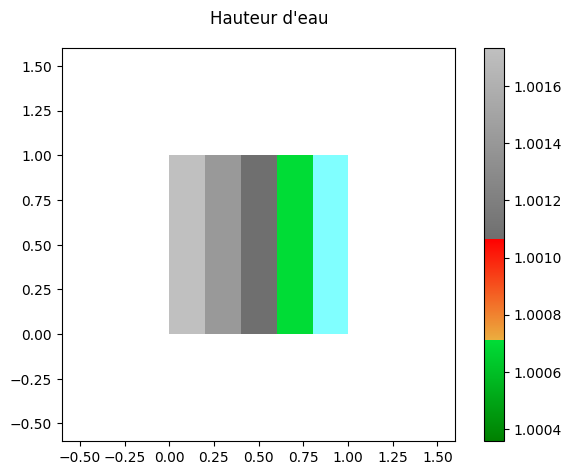

In [68]:

print('Minimum ', res[0].array.min())
print('Maximum ', res[0].array.max())

fig,ax = res[0].plot_matplotlib()
fig.suptitle('Hauteur d\'eau')
fig.colorbar(ax.images[0], ax=ax)
fig.tight_layout()
